In [1]:
import pyreadr
import pandas as pd

# .Rdata 파일 불러오기
result = pyreadr.read_r("./data_ml.RData")  # 'data.Rdata'를 적절한 파일명으로 변경

# 저장된 객체 확인
print(result.keys())  # 어떤 객체들이 저장되어 있는지 확인

# 첫 번째 데이터프레임을 가져오기
df = result[next(iter(result.keys()))]  # 여러 개가 있을 경우 첫 번째 데이터프레임을 가져옴

# CSV 파일로 저장
df.to_csv('data_ml.csv', index=False)


odict_keys(['data_ml'])


In [4]:
data_raw = pd.read_csv("./data_ml.csv")
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (data_raw['date'] < '2019-01-01')].tolist()

# 날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
# 날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6,0:6] # 데이터프레임 예시 출력

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
0,13,2006-12-31,0.25,0.33,0.27,0.22
1,13,2007-01-31,0.25,0.32,0.28,0.22
2,13,2007-02-28,0.26,0.30,0.30,0.22
3,17,2015-03-31,0.73,0.64,0.70,0.40
4,17,2015-04-30,0.72,0.62,0.66,0.40
5,17,2015-05-31,0.71,0.63,0.64,0.40


Text(0, 0.5, 'nb_assets')

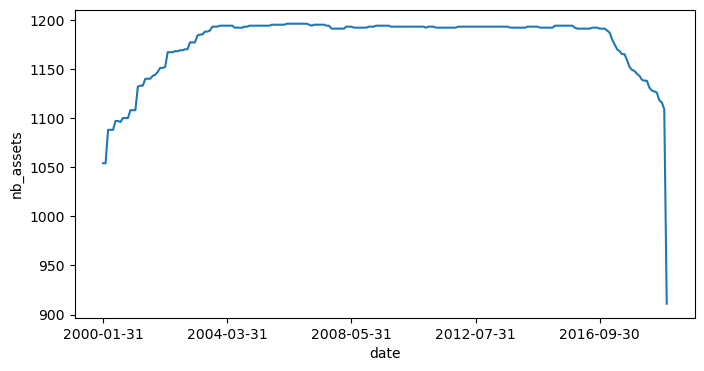

In [10]:
import matplotlib.pyplot as plt
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4))
# 각 날짜별 자산 개수 세기
plt.ylabel('nb_assets')
# y축 제목을 추가한 후 그래프 그리기

In [12]:
features = list(data_ml.iloc[:,3:95].columns)
# 특성의 열 이름을 저장해놓는다
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

Text(0, 0.5, 'count')

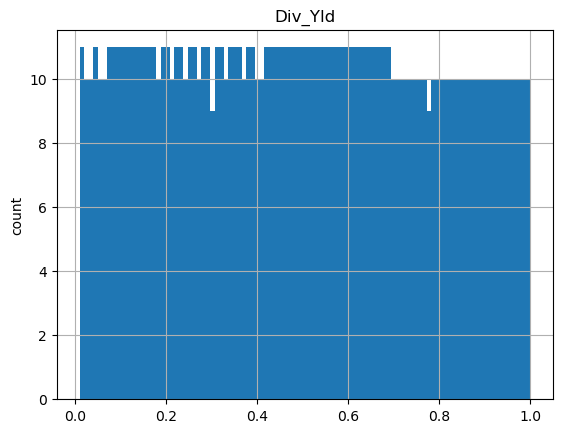

In [14]:
col_feat_Div_Yld = data_ml.columns.get_loc("Div_Yld")
# 특성 Div_Yld 열의 위치 찾기
is_custom_date = data_ml['date']=='2000-02-29'
# 필터링할 부울 인덱스 생성
data_ml[is_custom_date].iloc[:,[col_feat_Div_Yld]].hist(bins=100)
# 히스토그램 사용하기
plt.ylabel('count')

In [16]:
df_median=[]
df=[]
import numpy as np
df_median = data_ml[['date', 'R1M_Usd', 'R12M_Usd']].groupby(['date']).median() # 각 날짜별로 2개의 레이블에 대한 중간값 계산
df_median.rename(
    columns={"R1M_Usd" : "R1M_Usd_median",
             "R12M_Usd" : "R12M_Usd_median"}, inplace=True)

df = pd.merge(data_ml, df_median, how='left', on=['date']) # 데이터프레임 합치기

data_ml['R1M_Usd_C'] = np.where( # 범주형 레이블 생성
    df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where( # 범주형 레이블 생성
    df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)

/var/folders/kb/928zfwrs6f53ms02l47yq98r0000gn/T/ipykernel_12284/3690064292.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where( # 범주형 레이블 생성
/var/folders/kb/928zfwrs6f53ms02l47yq98r0000gn/T/ipykernel_12284/3690064292.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where( # 범주형 레이블 생성


In [17]:
separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

In [18]:
stock_ids_short=[] # 임시 데이터프레임을 위한 빈 리스트 생성
stock_days=[] # 임시 데이터프레임을 위한 빈 리스트 생성

stock_ids=data_ml['stock_id'].unique() # 모든 stock_ids의 리스트

stock_days=data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index() # 각 주식별 데이터 포인트 개수 세기
stock_ids_short=stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
# 데이터가 전부 있는 주식을
stock_ids_short=stock_ids_short['stock_id'].unique()
# 리스트로 변환
is_stock_ids_short=data_ml['stock_id'].isin(stock_ids_short)
returns=data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd') # 수익률 행렬